## Run Simulation Trials

The run script is the main entrypoint for this project. It has a number of options that can be dynamically set for a wide range of simulation scenarios. This are available for reference by passing the help flag as a parameter.

In [1]:
!./run.sh -h

./run.sh usage:
        -a  Select path planning algorithm/strategy (pso, aco or lawn).
        -b  Build the main argos project. Use after editing source files.
        -d  Set the number of drones to place in simulation.
        -e  Set experiment source file. Currently defaults to "main".
        I)  Create experiment environment and install package dependancies.
        -j  Run the jupyter environment.
        -n  Set number of targets/plants to place in simulation.
        N)  Set value range of targets/plants to place in simulation.
        -s  Set the number of independantly seeded trials to run.
        -t  Set the target coverage/inspection percentage during trial.
        -v  Enable argos vizualization. Disabled by default for speed.
        h | *)  Print this usage info.


Let's create a dataset with the following settings:
- Target Coverage Percentage of 90%
- Across all three path planning algorithms/strategies.
- Independantly seeding 3 random child trials per parent iteration.
- With a target/plant value range of 4.

In [3]:
!sudo -S ./run.sh -t "0.90" -a "aco" -s 1 -N "4" -v < pass

[sudo] password for jo: Building and making project...
-- Could NOT find GALIB (missing:  GALIB_LIBRARY GALIB_INCLUDE_DIR) 
-- Configuring done
-- Generating done
-- Build files have been written to: /media/jo/All/Linux/thesis/source/build
[  4%] Automatic moc for target main
[  4%] Built target main_automoc
[  8%] Automatic moc for target pso
[  8%] Built target pso_automoc
[ 39%] Built target pso
[ 43%] Automatic moc for target aco
[ 43%] Built target aco_automoc
[ 69%] Built target aco
[ 73%] Automatic moc for target kalman
[ 73%] Built target kalman_automoc
[ 86%] Built target kalman
[100%] Built target main
Done!
Beginning aco trial with ( targets = 1 )( threshold = 0.90 )( seed = 4254469523 )
Running main experiment...
Done!
( targets = 2 )( threshold = 0.90 )( seed = 2670130372 )
Running main experiment...
Done!
( targets = 3 )( threshold = 0.90 )( seed = 4021276007 )
Running main experiment...
Done!
( targets = 4 )( threshold = 0.90 )( seed = 528440029 )
Running main experiment

## Testing for Significance with the Independant Students' T-test

We will use the Independant Student's t-test to determine whether the difference between our **UAV-MRS** simulation datasets is significant. We first import the necessary python packages.

In [6]:
import pandas as pd
from scipy import stats
from math import sqrt
from scipy.stats import ttest_ind
from scipy.stats import t
import numpy as np
import matplotlib as plt

Convert the csv dataset into hdf5 format.

In [7]:
chunksize = 10 ** 4
filename = 'sample/data_0.csv'
headers = ['Type','TargetNum','TargetThresh','Step','Completed',
         'X','Y','Z','RtMProb','RtLProb','MinimumHold','LaunchStep',
         'InitialRtMProb','RtMDelta','InitialRtLProb','RtLDelta',
         'MinimumRest','InitialMinimumHold','MaximumHold','GlobalReach',
         'ProximityThresh','Attitude','SwarmParticles','SwarmSelfTrust',
         'SwarmPastTrust','SwarmGlobalTrust','SwarmAnts','MappingMean',
         'MappingStdDev','MappingSeed','RtMMin','RtMMax','RtMSeed','RtLMin',
         'RtLMax','RtLSeed','ACOSeed','TaskCompletedMin','TaskCompletedMax',
         'TaskCompletedSeed','TargetShuffleMin','TargetShuffleMax',
         'TargetShuffleSeed','NaiveMapping','VStep','HStep','ArgosSeed']

datatypes={
    'Type':np.string_,'TargetNum':np.uint8,'TargetThresh':np.uint8,'Step':np.uint32,'Completed':np.uint8,
    'X':np.float16,'Y':np.float16,'Z':np.float16,'RtMProb':np.float16,'RtLProb':np.float16,'MinimumHold':np.uint8,'LaunchStep':np.uint8,
    'InitialRtMProb':np.float16,'RtMDelta':np.float16,'InitialRtLProb':np.float16,'RtLDelta':np.float16,
    'MinimumRest':np.uint8,'InitialMinimumHold':np.uint8,'MaximumHold':np.uint8,'GlobalReach':np.float16,
    'ProximityThresh':np.float16,'Attitude':np.float16,'SwarmParticles':np.uint8,'SwarmSelfTrust':np.float16,
    'SwarmPastTrust':np.float16,'SwarmGlobalTrust':np.float16,'SwarmAnts':np.uint8,'MappingMean':np.float16,
    'MappingStdDev':np.float16,'MappingSeed':np.uint8,'RtMMin':np.uint8,'RtMMax':np.uint8,'RtMSeed':np.uint16,'RtLMin':np.uint8,
    'RtLMax':np.uint8,'RtLSeed':np.uint8,'ACOSeed':np.uint8,'TaskCompletedMin':np.uint8,'TaskCompletedMax':np.uint8,
    'TaskCompletedSeed':np.uint8,'TargetShuffleMin':np.uint8,'TargetShuffleMax':np.uint8,
    'TargetShuffleSeed':np.uint8,'NaiveMapping':np.string_,'VStep':np.float16,'HStep':np.float16,'ArgosSeed':np.uint8
}

def saveAsHDF(chunk):
    chunk.loc[chunk['Type'] == 'pso'].to_hdf('sample/pso.h5',  key = 'data', mode ='a', format='table', append = True)
    chunk.loc[chunk['Type'] == 'aco'].to_hdf('sample/aco.h5',  key = 'data', mode ='a', format='table', append = True)
    chunk.loc[chunk['Type'] == 'lawn'].to_hdf('sample/lawn.h5',  key = 'data', mode ='a', format='table', append = True)

for chunk in pd.read_csv(filename, chunksize=chunksize, dtype=datatypes):
    saveAsHDF(chunk)

We then load our categorised hdf5 datasets piecemeal and compute their means.

In [8]:
# Compute the pso means first
pso_f = pd.read_hdf('sample/pso.h5', 'data')
pso_target_thresh = pso_f.groupby('TargetNum', as_index=False).apply(lambda row: row[row['Completed'] == row['TargetThresh']])
pso_step_means = pso_target_thresh.groupby('ArgosSeed').head(1).groupby('TargetNum')['Step'].mean()

del pso_f, pso_target_thresh

print(pso_step_means)

TargetNum
2       407.750000
3       741.333333
4       723.500000
5       774.000000
12     4277.500000
13     4567.500000
14     4929.500000
15     4898.666667
16     6384.000000
17     6490.666667
18     4734.000000
19     6814.250000
20     5080.000000
21     5693.000000
22     5367.333333
23     5520.000000
24     5912.333333
25     5872.000000
26     7719.000000
27     6422.000000
28     8114.333333
29     7109.000000
30     6790.666667
31     6456.000000
32     6609.500000
33     6516.000000
34     6522.000000
35     6663.500000
36     6994.000000
37     7179.500000
38     7111.000000
39    13980.500000
41    18057.000000
42    19607.500000
43     8332.000000
44    18151.000000
45    12921.750000
46    16939.000000
47    12512.000000
50    17104.000000
Name: Step, dtype: float64


In [9]:
# Compute the aco means
aco_f = pd.read_hdf('sample/aco.h5', 'data')
aco_target_thresh = aco_f.groupby('TargetNum', as_index=False).apply(lambda row: row[row['Completed'] == row['TargetThresh']])
aco_step_means = aco_target_thresh.groupby('ArgosSeed').head(1).groupby('TargetNum')['Step'].mean()

del aco_f, aco_target_thresh

print(aco_step_means)

TargetNum
2       407.250000
3       749.250000
4       748.250000
5       774.000000
11     4613.000000
12     4607.250000
13     4903.000000
14     4917.000000
15     4887.666667
16     6388.000000
17     7362.500000
18     4784.000000
19     5789.666667
20     5653.500000
21     5460.500000
22     5236.500000
23     5619.000000
24     5374.500000
25     5592.666667
26     6404.000000
27     6690.250000
28     7583.500000
29     6306.000000
30     6839.000000
31     6392.000000
32     6890.250000
33     6494.000000
34     6710.500000
35     7047.000000
36     6990.000000
37     7148.500000
38     7172.500000
41    16641.333333
42    19125.500000
43     8384.000000
44    13736.333333
45    18103.000000
46    16866.000000
47    17920.000000
48    12460.500000
49     7362.000000
50    14833.666667
Name: Step, dtype: float64


In [10]:
# Compute the lawns means
lawn_f = pd.read_hdf('sample/lawn.h5', 'data')
lawn_target_thresh = lawn_f.groupby('TargetNum', as_index=False).apply(lambda row: row[row['Completed'] == row['TargetThresh']])
lawn_step_means = lawn_target_thresh.groupby('ArgosSeed').head(1).groupby('TargetNum')['Step'].mean()

del lawn_f, lawn_target_thresh

print(lawn_step_means)

TargetNum
2      1568.000000
3      7124.500000
4      4703.500000
5      4392.666667
6     37454.666667
7     40422.500000
8     52885.666667
9     58873.333333
10    62929.000000
11    47983.000000
12    59524.000000
13    55488.666667
14    62760.666667
15    55574.000000
16    62564.666667
17    67697.666667
18    60794.500000
19    61050.333333
20    60168.000000
21    57930.000000
22    64139.333333
23    65296.000000
24    62720.500000
25    64694.000000
26    64817.000000
27    68636.000000
28    68121.000000
29    68660.000000
30    69506.000000
31    66764.000000
32    63040.666667
33    66437.500000
34    68573.000000
35    63840.666667
36    64729.666667
37    66329.000000
39    65774.000000
40    70448.000000
41    65415.500000
42    68494.000000
43    64944.666667
45    68592.750000
46    71788.000000
47    68698.666667
48    70158.000000
49    67806.666667
50    70162.000000
Name: Step, dtype: float64


Aggregate all the computed means.

In [11]:
backup = pd.HDFStore('sample/backup.h5')

# means = backup['means']
means = pd.DataFrame(columns=['pso', 'aco', 'lawn'])

means.pso = pso_step_means
means.aco = aco_step_means
means.lawn = lawn_step_means
means = means.dropna()

backup['means'] = means
print(means)

                    pso           aco          lawn
TargetNum                                          
2            407.750000    407.250000   1568.000000
3            741.333333    749.250000   7124.500000
4            723.500000    748.250000   4703.500000
5            774.000000    774.000000   4392.666667
12          4277.500000   4607.250000  59524.000000
13          4567.500000   4903.000000  55488.666667
14          4929.500000   4917.000000  62760.666667
15          4898.666667   4887.666667  55574.000000
16          6384.000000   6388.000000  62564.666667
17          6490.666667   7362.500000  67697.666667
18          4734.000000   4784.000000  60794.500000
19          6814.250000   5789.666667  61050.333333
20          5080.000000   5653.500000  60168.000000
21          5693.000000   5460.500000  57930.000000
22          5367.333333   5236.500000  64139.333333
23          5520.000000   5619.000000  65296.000000
24          5912.333333   5374.500000  62720.500000
25          

Perform independant student t-test

<IPython.core.display.Javascript object>


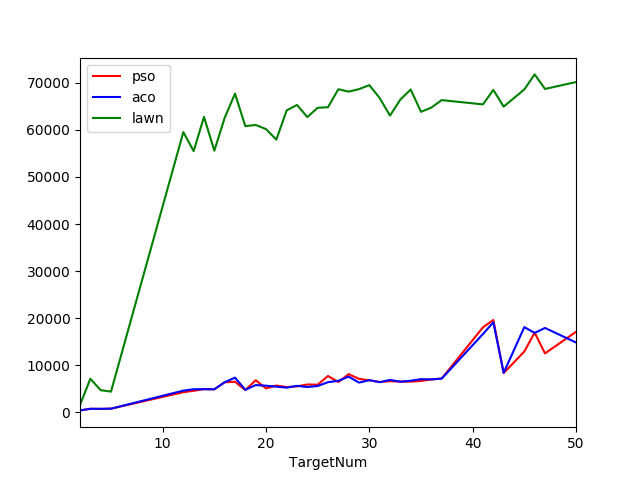

In [14]:
%matplotlib notebook

means.plot(style=['r-', 'b-', 'g-'])

<IPython.core.display.Javascript object>


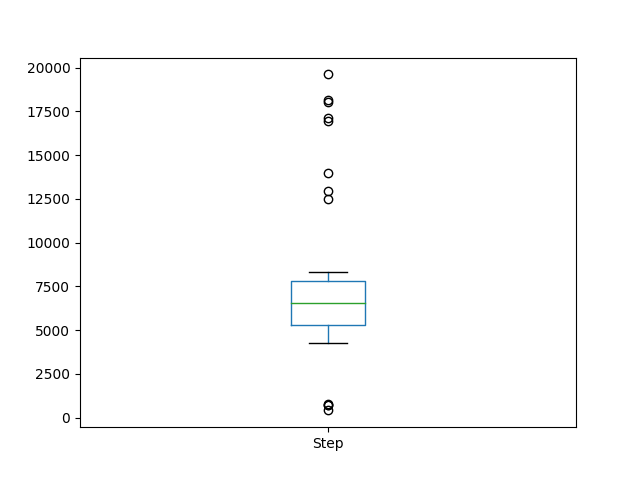

In [15]:
%matplotlib notebook

pso_step_mean_plot = pso_step_means.plot.box()
pso_step_mean_fig = pso_step_mean_plot.get_figure()
pso_step_mean_fig.savefig('thesis/images/pso_step_means.png')

<IPython.core.display.Javascript object>


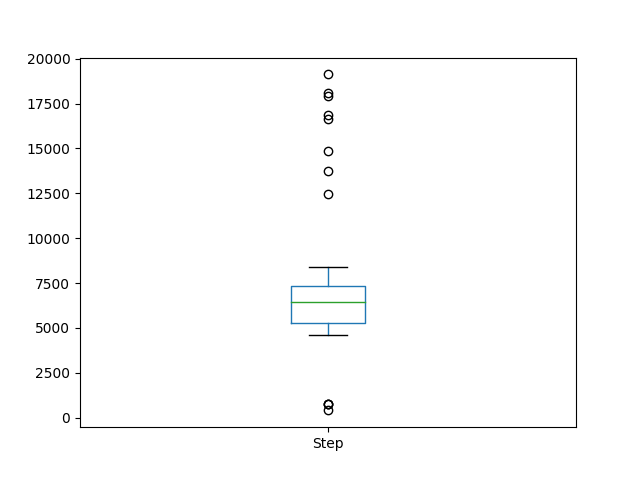

In [16]:
%matplotlib notebook

aco_step_mean_plot = aco_step_means.plot.box()
aco_step_mean_fig = aco_step_mean_plot.get_figure()
aco_step_mean_fig.savefig('thesis/images/aco_step_means.png')

<IPython.core.display.Javascript object>


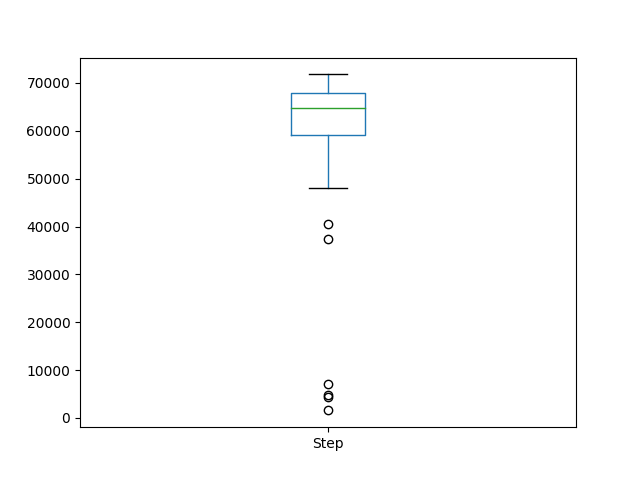

In [17]:
%matplotlib notebook

lawn_step_mean_plot = lawn_step_means.plot.box()
lawn_step_mean_fig = lawn_step_mean_plot.get_figure()
lawn_step_mean_fig.savefig('thesis/images/lawn_step_means.png')

<IPython.core.display.Javascript object>


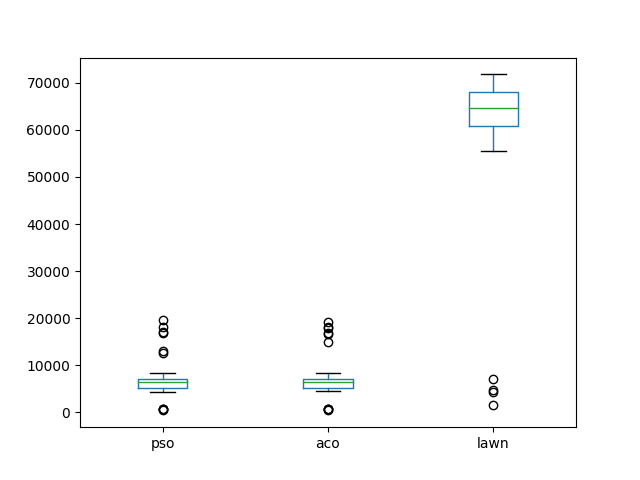

In [18]:
%matplotlib notebook

mean_plot = means.plot.box()
mean_fig = mean_plot.get_figure()
mean_fig.savefig('thesis/images/means.png')

Perform a t-test on the generated means.

In [19]:
print('T-test of pso and aco means: ', ttest_ind(means.pso,means.aco))
print('T-test of pso and lawn means: ', ttest_ind(means.pso,means.lawn))
print('T-test of aco and lawn means: ', ttest_ind(means.aco,means.lawn))

backup.close()

T-test of pso and aco means:  Ttest_indResult(statistic=-0.12032101060246614, pvalue=0.9045639903764315)
T-test of pso and lawn means:  Ttest_indResult(statistic=-15.579680541684782, pvalue=9.221955156662362e-25)
T-test of aco and lawn means:  Ttest_indResult(statistic=-15.491671397294775, pvalue=1.2641737720321469e-24)


We have a p-value of ~0.9 between aco and pso, indicating that there is no statistical significance between the two means. More interestingly though, we have p-values of < 0.05 when performed against pso/aco and the lawn means, this is an indication of statistical significance, telling us that our null-hypothesis is provably false!